<a href="https://colab.research.google.com/github/jtlai0921/-/blob/master/keras_05_1transferlearning_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [5]:
IMG_SIZE = 100
class_map = {
    'PS':0,
    'Sc':1,
    'RS':2,
    'In':3,
    'Cr':4,
    'Pa':5
}

(200, 200, 3)


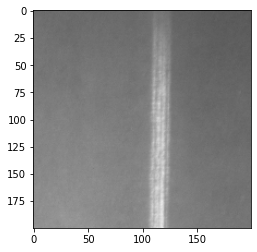

In [6]:
# Read single image
data_path = '/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/NEU_defect/*.bmp' 
img_paths = glob(data_path)
# demo for 300 images
img_paths = np.random.choice(img_paths, 300)

img = cv2.imread(img_paths[0])
plt.imshow(img)
print(img.shape)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((200, 200, 3), (100, 100, 3))

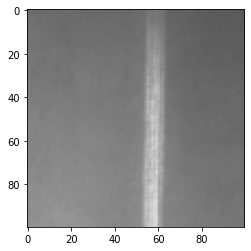

In [8]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [9]:
# Extract img class
img_path = img_paths[0]
img_path

'/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/NEU_defect/Sc_35.bmp'

In [10]:
cls = img_path.split('/')[-1].split('_')[0]
cls

'Sc'

In [11]:
class_map[cls]

1

# Read images and labels

In [12]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))
print(data_count, X.shape, y.shape)

300 (300, 100, 100, 3) (300,)


# Method 1: Load Image and labels from scratch

In [13]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-1].split('_')[0]
    X[i] = img_resize
    y[i] = class_map[cls]

# Method2: load Images and labels from pickle file

In [14]:
import pickle
with open('/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/y.pickle', 'rb') as file:
    X = pickle.load(file)
with open('/content/drive/MyDrive/緯育AI瑕疵檢測/Day2/y.pickle', 'rb') as file:
    y = pickle.load(file)
X.shape, y.shape

((1800, 1), (1800, 1))

TypeError: ignored

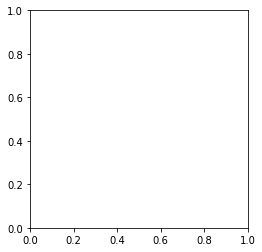

In [17]:
idx = 50
plt.imshow(X[idx]/255.)
print(y[idx])

### Label statistics

In [18]:
# number of samples of each classes
unique_label, counts = np.unique(y, return_counts=True)
print(unique_label)
print(counts)

[0. 1. 2. 3. 4. 5.]
[300 300 300 300 300 300]


### Preprocessing

In [21]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from tensorflow.keras.applications.vgg16 import preprocess_input
X = preprocess_input(X) # preprocess images

y_onehot = tf.keras.utils.to_categorical(y, num_classes=6) # one hot encoding

IndexError: ignored

In [23]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

NameError: ignored

### Build Model

In [24]:
# Model 0: Use VGG16 as base model without pretrained weights
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(base_model.input, predictions)

In [25]:
# Model 1: Use VGG16 as base model
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(base_model.input, predictions)

58892288/58889256 [==============================] - 0s 0us/step


In [26]:
# Model 2: VGG16 with freeze layers
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(base_model.input, predictions)

# Freeze ALL VGG layers
for layer in base_model.layers[:]:
    layer.trainable = False


In [27]:
# Model 3: Extract features from an arbitrary intermediate layer with VGG19
base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# get layer by name
features = base_model.get_layer('block2_pool').output
# get layer by layer index
# features = base_model.layers[6].output

x = GlobalAveragePooling2D()(features)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(base_model.input, predictions)

In [28]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [29]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# checkpoint = ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
#                              monitor='val_loss', 
#                              save_weights_only=False)
checkpoint2 = ModelCheckpoint('drive/My Drive/vgg.h5',
                              monitor='val_loss', 
                              save_weights_only=False, 
                              save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)


### Training

In [32]:
logs = model.fit(X_train, y_train,
                 batch_size=32,
                 epochs=10000,
                 verbose=1,
                 callbacks=[early_stopping, reduce_lr, checkpoint2],     
                 validation_data=(X_test, y_test))

NameError: ignored

In [33]:
history = logs.history

NameError: ignored

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

NameError: ignored

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(y_true.shape, y_pred.shape)

target_names = [str(i) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names))

NameError: ignored

In [38]:
print(confusion_matrix(y_true, y_pred))

NameError: ignored

# Prediction

In [40]:
idx = 100
imgs = X_test[idx:idx+1]
label = y_test[idx:idx+1]
pred = model.predict(imgs)
print(label, pred)
print(np.argmax(label), np.argmax(pred))

NameError: ignored